In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from datetime import datetime
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt


#
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv('train.csv')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
#only 10 rows with missing data just dropping
data = data[data['MISSING_DATA'] == False]

In [5]:
def polyline_to_trip_duration(polyline):
    return max(polyline.count("[") - 2, 0) * 15 #subtracting 2 because one is for the opening bracket?

# This code creates a new column, "LEN", in our dataframe. The value is
# the (polyline_length - 1) * 15, where polyline_length = count("[") - 1
data["LEN"] = data["POLYLINE"].apply(polyline_to_trip_duration)

**Making time columns**

In [6]:
def parse_time(x):
    dt = datetime.fromtimestamp(x["TIMESTAMP"])
    return dt.year, dt.month, dt.day, dt.hour, dt.weekday()

In [7]:
data[["YR", "MON", "DAY", "HR", "WK"]] = (
    data[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
)

In [8]:
#filling nan's with -1 to avoid errors
data['ORIGIN_STAND'].fillna(-1, inplace = True)

In [9]:
type_map = {'A': 1, 'B': 2, 'C': 3}
data['CALL_TYPE'] = data['CALL_TYPE'].map(type_map).astype(int) 
data['DAY_TYPE'] = data["DAY_TYPE"].map(type_map).astype(int) 

In [10]:
#since the data is very wide after onehotencoding, we'll do a 90-10 split to give the model more data
train, valid = train_test_split(data, train_size = 0.90)

In [11]:
del data  #clearing memory since this dataframe is now redundant

**Add interaction terms** ?
- day * hour
- hour * origin stand
- day_type * origin stand

## Data engineering
- Should all the features be categorical? Seems wrong

In [12]:
from sklearn.preprocessing import PolynomialFeatures

In [13]:
X_train = train[["YR", "MON", "DAY", "HR", "WK", 'ORIGIN_STAND', 'CALL_TYPE']]
Y_train = train["LEN"]

In [14]:
X_valid = valid[["YR", "MON", "DAY", "HR", "WK", 'ORIGIN_STAND', 'CALL_TYPE']] 
Y_valid = valid["LEN"]

## Using one hot encoder

In [15]:
#onehot encoding
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

encoder.fit(X_train[X_train.columns])
X_train_OH = encoder.transform(X_train[X_train.columns])

X_train = torch.Tensor(X_train_OH).to(device)

In [16]:
X_valid_OH = encoder.transform(X_valid[X_valid.columns])

X_valid_OH = torch.Tensor(X_valid_OH).to(device)

In [25]:
batch_size = 128
dataset = torch.utils.data.TensorDataset(X_train, torch.from_numpy(Y_train.values))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
class DeepModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DeepModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_size), #added batchnorm
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            #nn.ReLU(),
            #nn.Linear(100, 1)
        )
    
    def forward(self, data):
        
        # Pass through the encoder
        output = self.encoder(data)
        
        return output.squeeze()

In [18]:
class DeeperModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(DeeperModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 2*hidden_size), #added another hidden layer compared to writeup
            nn.LeakyReLU(),
            nn.Linear(2*hidden_size, hidden_size), #added another hidden layer compared to writeup
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size), #added batchnorm, is this correct?
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 1)
        )
    
    def forward(self, data):
        
        # Pass through the encoder
        output = self.encoder(data)
        
        return output.squeeze()

In [19]:
X_train.size()

torch.Size([1454061, 143])

In [46]:
hidden_size = 1024 #large because of the onehot encoding, we need a wide model

model = DeepModel(10296, #changed from X_train.size(1)
                   hidden_size).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4) #can try 1e-4, similar results

In [47]:
#deep network



losses = []
valid_losses = []
for epoch in range(5):
    start_time = time.time()
    
    running_loss = 0
    n = 0
    
    print(f"-------------------------------")
    

    # Loop over batches in an epoch using DataLoader
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        
        interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        x_batch = torch.Tensor(
            interactions.fit_transform(x_batch.cpu())
        )
        
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
    

        y_batch_pred = model(x_batch)


        loss = loss_fn(y_batch_pred, y_batch.float())
        running_loss += loss.item()
        n += 1

        # backwards steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Time of epoch {epoch + 1}: {time.time() - start_time} seconds')
        
    print(f"Epoch {epoch + 1} training loss: {np.sqrt(running_loss/n)}")
    
    #valid_epoch = model(X_valid_OH).detach().cpu().numpy()
    #val_loss = rmse(valid_epoch, Y_valid)
    #print(f'Validation loss: {val_loss}')
    
    losses.append(np.sqrt(running_loss/n))
    #valid_losses.append(val_loss)

    


-------------------------------
Time of epoch 1: 147.28156995773315 seconds
Epoch 1 training loss: 680.489791690228
-------------------------------
Time of epoch 2: 140.23842406272888 seconds
Epoch 2 training loss: 671.0932236633018
-------------------------------
Time of epoch 3: 156.88070607185364 seconds
Epoch 3 training loss: 669.1003411932471
-------------------------------
Time of epoch 4: 141.5887234210968 seconds
Epoch 4 training loss: 667.0408019176109
-------------------------------
Time of epoch 5: 153.47037768363953 seconds
Epoch 5 training loss: 665.0471969341506


In [111]:
#how to stop loss from converging here? need a more complex model? 
    #A: one hot encoding makes the data sparse, so we need a much wider model. 
    #with this additional width, we need to make the model deeper as well in order to make sure
    #it sees enough data
#should we do a different encoding?

#why is loss so different on validation vs test? which loss should we believe?

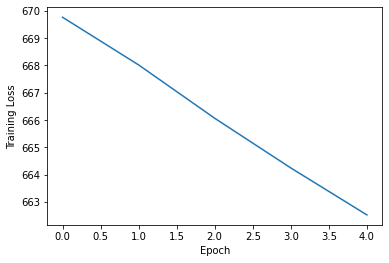

In [27]:
plt.plot(losses)
#plt.plot(valid_losses)
plt.ylabel('Training Loss')
plt.xlabel('Epoch')
plt.savefig('loss_by_epoch.png')
plt.show()

In [42]:
X_valid_OH = encoder.transform(X_valid[X_valid.columns])

X_valid_OH = torch.Tensor(X_valid_OH).to(device)

In [43]:
Y_valid.values

array([ 315,  255,  195, ..., 1350,  750,  390])

In [44]:
val_preds = model(X_valid_OH)
np.sqrt(
    F.mse_loss(val_preds.cpu(), 
               torch.Tensor(Y_valid.values)).detach().numpy()
)

664.5225

In [46]:
print(pd.Series(val_preds.detach().cpu()).nunique()/len(val_preds))

0.42068363477644105


**Hyperparameter tuning**

In [19]:
learning_rates = [5e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]
hidden_sizes = [128, 256, 512, 1024]
#define model
for lr in learning_rates:
    
    for hidden_size in hidden_sizes:
        
        model = DeepModel(X_train.size(1),
                           hidden_size).to(device)
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        
        print(f"-------------------------------")
        
        
        losses = []
        for epoch in range(3):
            start_time = time.time()

            running_loss = 0
            n = 0

            # Loop over batches in an epoch using DataLoader
            for batch_idx, (x_batch, y_batch) in enumerate(train_loader):

                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)


                y_batch_pred = model(x_batch)


                loss = loss_fn(y_batch_pred, y_batch.float())
                running_loss += loss.item()
                n += 1

                # backwards steps
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            #print(f'Time of epoch {epoch + 1}: {time.time() - start_time} seconds')
            
            if epoch == 2:
                print(f"LR: {lr}, size: {hidden_size}\n Loss: {np.sqrt(running_loss/n)}")
                losses.append(np.sqrt(running_loss/n))



-------------------------------
LR: 0.5, size: 128
 Loss: 686.6440361774972
-------------------------------
LR: 0.5, size: 256
 Loss: 686.6473317833044
-------------------------------
LR: 0.5, size: 512
 Loss: 686.6414258090298
-------------------------------
LR: 0.5, size: 1024
 Loss: 686.6549456522384
-------------------------------
LR: 0.01, size: 128
 Loss: 673.459939999522
-------------------------------
LR: 0.01, size: 256
 Loss: 673.3501568113429
-------------------------------
LR: 0.01, size: 512
 Loss: 673.1819186666024
-------------------------------
LR: 0.01, size: 1024
 Loss: 672.9186133251183
-------------------------------
LR: 0.001, size: 128
 Loss: 672.9877717424525
-------------------------------
LR: 0.001, size: 256
 Loss: 672.8936539054798
-------------------------------
LR: 0.001, size: 512
 Loss: 672.7044547102497
-------------------------------
LR: 0.001, size: 1024
 Loss: 672.5458404702964
-------------------------------
LR: 0.0001, size: 128
 Loss: 676.012301706

### Analyzing trips which were hard to predict

In [ ]:
#not enough memory
y_train_pred = model.cpu()(X_train.cpu())
with_preds = train.copy()
with_preds['diff'] = abs(train['LEN'] - y_train_pred)

ten_worst = with_preds.sort_values(by = 'diff', ascending = False).iloc[:10][['POLYLINE', 'diff']]

In [ ]:
def plot_polyline(polyline):
    x = [point[0] for point in polyline]
    y = [point[1] for point in polyline]

    plt.plot(x, y, '-o')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Polyline Plot')
    plt.grid(True)
    plt.show()


for i in range(10):
    plot_polyline(
        eval(
            ten_worst.reset_index()['POLYLINE'].iloc[i]
        )
        )
    

### Prediction file

In [28]:
test_data = pd.read_csv('test_public.csv')

In [29]:
test_data[["YR", "MON", "DAY", "HR", "WK"]] = (
    test_data[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
)

In [33]:
X_test = test_data[["YR", "MON", "DAY", "HR", "WK", 'ORIGIN_STAND', 'CALL_TYPE']]

In [34]:
X_test_OH = encoder.transform(X_test[X_test.columns])
X_test_OH = interactions.transform(X_test_OH)

X_test = torch.Tensor(X_test_OH).to(device)

In [35]:
preds = model(X_test)

In [37]:
final_preds = pd.DataFrame({'TRIP_ID': test_data['TRIP_ID'], 'TRAVEL_TIME': train['LEN'].mean()})

In [38]:
final_preds = pd.DataFrame({'TRIP_ID': test_data['TRIP_ID'], 'TRAVEL_TIME': preds.cpu().detach()})

final_preds.to_csv('interaction_test_preds.csv', index = False)

## Embedding

**Not in use**  
We still need to debug this, but it's our idea for how to improve the model next.

In [64]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, dropped_columns):
        self.data = dataframe.drop(columns=dropped_columns)#.values
        self.targets = dataframe["LEN"].astype(float).values
        print(self.data.columns)
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        print(self.data[idx])
        x = torch.tensor(self.data[idx], dtype=torch.float32)
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
        return x, y


dataset = CustomDataset(train, dropped_columns=['LEN', 'POLYLINE', 
                                                'MISSING_DATA', 'TRIP_ID', 'ORIGIN_CALL',
                                               "DAY_TYPE", 'TAXI_ID'])

Index(['CALL_TYPE', 'ORIGIN_STAND', 'TIMESTAMP', 'YR', 'MON', 'DAY', 'HR',
       'WK'],
      dtype='object')


In [12]:
class PandasDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe):
        self.targets = dataframe["LEN"].astype(float).values
        self.data = dataframe[['CALL_TYPE', 'ORIGIN_STAND', 'YR', 'MON', 'DAY', 'HR', 'WK']]
        self.call_type_mapping = {'A': 0, 'B': 1, 'C': 2}
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = self.data.iloc[idx, :].copy()
        x['CALL_TYPE'] = self.call_type_mapping[x['CALL_TYPE']]
        
        y = torch.tensor(self.targets[idx], dtype=torch.float32)
     
        return torch.from_numpy(x.values.astype(np.float32)), y

dataset = PandasDataset(train)

In [14]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Test Model

In [13]:
class EmbedModel(nn.Module):
    def __init__(self, embedding_sizes, embedding_dim, hidden_size):
        super(EmbedModel, self).__init__()
        self.embedding_layers = nn.ModuleList([
            nn.Embedding(num_categories, embedding_dim) for num_categories in embedding_sizes
        ])
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.fc = nn.Linear(embedding_dim * len(embedding_sizes), hidden_size)
        self.relu = nn.ReLU()
        self.output_layer = nn.Linear(hidden_size, 1)
    
    def forward(self, data):
        embedded_data = [
            embedding_layer(data[:, i]) for i, embedding_layer in enumerate(self.embedding_layers)
        ]
        embedded_data = torch.cat(embedded_data, dim=1)
        x = self.fc(embedded_data)
        x = self.relu(x)
        output = self.output_layer(x)
        return output.squeeze()

In [14]:
embedding_sizes = X_train.nunique().values

In [15]:
call_map = {'A': 1, 'B': 2, 'C': 3}
X_train['CALL_TYPE'] = X_train['CALL_TYPE'].map(call_map).astype(int) 

/tmp/ipykernel_665/1164054414.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['CALL_TYPE'] = X_train['CALL_TYPE'].map(call_map).astype(int)


In [16]:
X_train = torch.Tensor(X_train.to_numpy())

In [17]:
batch_size = 64
dataset = torch.utils.data.TensorDataset(X_train, torch.from_numpy(Y_train.values))
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [18]:
model = EmbedModel(embedding_sizes, 
                   64, 
                   100).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [19]:
losses = []
for epoch in range(5):
    start_time = time.time()
    
    running_loss = 0
    n = 0
    
    print(f"-------------------------------")
    

    # Loop over batches in an epoch using DataLoader
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        
        x_batch = x_batch.to(device).long()
        y_batch = y_batch.to(device)
    

        y_batch_pred = model(x_batch)


        loss = loss_fn(y_batch_pred, y_batch.float())
        running_loss += loss.item()
        n += 1

        # backwards steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Time of epoch {epoch + 1}: {time.time() - start_time} seconds')
        
    print(f"Epoch {epoch + 1} loss: {np.sqrt(running_loss/n)}")
    losses.append(np.sqrt(running_loss/n))

-------------------------------


../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [12,0,0], thread: [32,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [12,0,0], thread: [33,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [12,0,0], thread: [34,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [12,0,0], thread: [35,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [12,0,0], thread: [36,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [12,0,0], thread: [37,0,0] Assertion `srcIndex < srcSelectDimSize` failed.
../aten/src/ATen/native/cuda/Indexing.cu:1146: indexSelectLargeIndex: block: [12,0,0], t

RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`

**Older model**
____

In [36]:
class BasicModel(nn.Module):
    def __init__(self, num_call_types, num_origin_stands, embedding_dim, hidden_size):
        super(BasicModel, self).__init__()
        
        # Embedding layers
        self.call_type_embedding = nn.Embedding(num_call_types, embedding_dim)
        self.origin_stand_embedding = nn.Embedding(num_origin_stands, embedding_dim)
        
        self.encoder = nn.Sequential(
            nn.Linear(24, hidden_size), 
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, call_type, ):
        call_type_embedded = self.call_type_embedding(call_type)
        origin_stand_embedded = self.origin_stand_embedding(origin_stand)

        hour = hour.unsqueeze(1)
        day = day.unsqueeze(1)
        month = month.unsqueeze(1)
        year = year.unsqueeze(1)

        # Concatenating
        features = torch.cat([hour, day, month, year, call_type_embedded, origin_stand_embedded], dim=1)

        output = self.encoder(features)
        
        return output


In [37]:
#not sure about input size
num_call_types = train['CALL_TYPE'].nunique() 
num_origin_stands = train['ORIGIN_STAND'].nunique() 
embedding_dim = 10 #arbitrary
hidden_size = 64 #arbitrary

model = BasicModel(num_call_types, 
                   num_origin_stands, embedding_dim, 
                   hidden_size).to(device)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

In [38]:
#deep network (not lstm)

for epoch in range(5):
    
    running_loss = 0
    n = 0
    
    print(f"Epoch {epoch + 1}\n-------------------------------")

    # Loop over batches in an epoch using DataLoader
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
        
        
        call_type = x_batch[:, 0].long()
        origin_stand = x_batch[:, 1].long()
        year = x_batch[:, 2]  
        month = x_batch[:, 3]  
        day = x_batch[:, 4]
        hour = x_batch[:, 5]
        week = x_batch[:, 6]
        
        min_origin_stand = torch.min(origin_stand)
        origin_stand_processed = origin_stand - min_origin_stand

        y_batch_pred = model(hour, day, month, year, call_type, origin_stand_processed)


        loss = loss_fn(y_batch_pred[0], y_batch.float())
        running_loss += loss.item()
        n += 1

        # backwards steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
    print(f"Epoch {epoch + 1} loss: {running_loss/n}")

Epoch 1
-------------------------------


NameError: name 'train_loader' is not defined

In [20]:
hidden_state = (torch.zeros(1, hidden_size).to(device),
                torch.zeros(1, hidden_size).to(device))

# https://stackoverflow.com/questions/51735001/how-to-include-batch-size-in-pytorch-basic-example
for epoch in range(5):
    
    running_loss = 0
    n = 0
    
    print(f"Epoch {epoch + 1}\n-------------------------------")

    # Loop over batches in an epoch using DataLoader
    for id_batch, (x_batch, y_batch) in enumerate(train_loader):
        
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        y_batch_pred = model(x_batch, hidden_state)

        loss = loss_fn(y_batch_pred[0], y_batch.float())
        running_loss += loss.item()
        n += 1

        # backwards steps
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        
    print(f"Epoch {epoch + 1} loss: {running_loss/n}")

Epoch 1
-------------------------------
Epoch 1 loss: 474716.41855863854
Epoch 2
-------------------------------
Epoch 2 loss: 474706.96882588905
Epoch 3
-------------------------------
Epoch 3 loss: 474695.4468317422
Epoch 4
-------------------------------
Epoch 4 loss: 474669.8388911181
Epoch 5
-------------------------------
Epoch 5 loss: 474651.3308392597


In [28]:
X_valid = valid[["YR", "MON", "DAY", "HR", "WK", 'ORIGIN_STAND']]

X_valid_OH = encoder.transform(X_valid[X_valid.columns])

X_valid = torch.Tensor(X_valid_OH).to(device)

In [36]:
hidden_state = (torch.zeros(1, hidden_size).to(device),
                torch.zeros(1, hidden_size).to(device))
valid_preds = model(X_valid)#[0]

In [37]:
valid_preds

tensor([[711.6207],
        [708.5093],
        [714.1364],
        ...,
        [714.6372],
        [719.8740],
        [717.0795]], device='cuda:0', grad_fn=<LeakyReluBackward0>)

## Prediction file

In [57]:
test_data = pd.read_csv('test_public.csv')

In [39]:
test_data[["YR", "MON", "DAY", "HR", "WK"]] = (
    test_data[["TIMESTAMP"]].apply(parse_time, axis=1, result_type="expand")
)

In [40]:
X_test = test_data[["YR", "MON", "DAY", "HR", "WK", 'ORIGIN_STAND']]

In [41]:
X_test_OH = encoder.transform(X_test[X_test.columns])

X_test = torch.Tensor(X_test_OH).to(device)

In [44]:
preds = model(X_test).squeeze()

In [58]:
final_preds = pd.DataFrame({'TRIP_ID': test_data['TRIP_ID'], 'TRAVEL_TIME': train['LEN'].mean()})

In [61]:
final_preds = pd.DataFrame({'TRIP_ID': test_data['TRIP_ID'], 'TRAVEL_TIME': preds.cpu().detach()})

final_preds.to_csv('test_preds.csv', index = False)

# Old code, can ignore
----------------------------

In [21]:
train_fraction[train_fraction['ORIGIN_STAND'].isna()].shape[0] 

263863

In [11]:
train_fraction = train.sample(500_000)

In [12]:
X = train_fraction[["YR", "MON", "DAY", "HR", "WK", 'ORIGIN_STAND']]
y = train_fraction['LEN']

In [13]:
full_Y = torch.tensor(y.values)

In [14]:
full_X = torch.from_numpy(X.values.astype('float32'))

In [15]:
model_1 = torch.nn.Sequential(
torch.nn.Linear(6, 1))

loss_fn = torch.nn.MSELoss()

# Define optimizer (this will perform your parameter updates use)
lr = 5e-3
opt = torch.optim.SGD(model_1.parameters(), lr=lr)

In [16]:
test = train.sample(500_000)
X_test_pd = test[["YR", "MON", "DAY", "HR", "WK", 'ORIGIN_STAND']]
y_test_pd = test['LEN']

y_test = torch.tensor(y_test_pd.values)
X_test = torch.tensor(X_test_pd.values)



In [ ]:
train_err = []
test_err = []
parameters = []
for i in range(100):
    model_1.train()
  
    y_pred = model_1(full_X) # Compute model outputs
    loss = loss_fn(y_pred, full_Y) # Compute MSE
    opt.zero_grad() # Must reset the gradients every step. Otherwise, gradients from previous iterations would cause interference!!!
    loss.backward() # Compute gradients of all parameters (our model) with respect to our computed loss value (a singular value)
    opt.step() # One gradient step
  
    train_err.append(loss.item())
  
    model_1.eval()
    with torch.no_grad():
        test_err.append(loss_fn(model_1(X_test), y_test).item())

/Users/orenciolli/anaconda3/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([500000])) that is different to the input size (torch.Size([500000, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [17]:
model_1(X_test)

RuntimeError: mat1 and mat2 must have the same dtype

---------------------------------

In [28]:
#train_fraction['POLYLINE'] = train_fraction['POLYLINE'].apply(lambda x: np.array(eval(x)).astype('float64'))

In [16]:
#train_fraction.groupby('ORIGIN_STAND').mean(numeric_only = True).plot(kind = 'bar', y = 'TRIP_LENGTH')

In [19]:
train_fraction['ORIGIN_STAND'].nunique()

63

Predicted important variables: polyline, interaction between timestamp and origin stand

In [9]:
X = np.array(
    train_fraction[['CALL_TYPE', 'ORIGIN_CALL', 'ORIGIN_STAND', 'TIMESTAMP', 'DAY_TYPE', 'POLYLINE']]
)

In [8]:
from ast import literal_eval

In [6]:
first_x = train_fraction['POLYLINE'].iloc[1]

In [35]:
train_fraction['POLYLINE'].iloc[0].dtype

dtype('float64')

In [49]:
test_type = np.array([train_fraction['POLYLINE'].iloc[0], train_fraction['POLYLINE'].iloc[1]])

/var/folders/dl/8n__h2151hd3n3gtfckwb75w0000gn/T/ipykernel_28498/3306076192.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  test_type = np.array([train_fraction['POLYLINE'].iloc[0], train_fraction['POLYLINE'].iloc[1]])


In [54]:
a = np.array([
    np.array([0.5, 1.0, 2.0], dtype=np.float16),
    np.array([4.0, 6.0, 8.0], dtype=np.float16),
])

b = torch.from_numpy(a)

In [64]:
np.array(train_fraction['POLYLINE'])[0][0][0]

-8.59509

In [69]:
three_d = np.array([
    np.array([
        np.array([1, 2]),
        np.array([2, 3])
    ]),
    np.array([
        np.array([1, 2]),
        np.array([2, 3])
    ])
])

In [85]:
three_d.shape#[0][0]

(2, 2, 2)

In [91]:
train_fraction['POLYLINE'].iloc[0][0]

array([-8.59509 , 41.146434])

In [71]:
torch.from_numpy(three_d)

tensor([[[1, 2],
         [2, 3]],

        [[1, 2],
         [2, 3]]])

In [89]:
torch.from_numpy(train_fraction['POLYLINE'].to_numpy())

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [17]:
torch.tensor(train_fraction['POLYLINE'].values)

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.